This notebook was prepared by [Author](https://github.com/ankitksharma). Source and license info is on [GitHub](https://github.com/ankitksharma/interactive-coding-challenges).

# Solution Notebook: Linear Regression using TensorFlow

## Problem: 

#### Implement Linear Regression model, which has a predict function which makes prediction on input data using `TensorFlow` library

* [Constraints](#Constraints)
* [Algorithm](#Algorithm)
* [Code](#Code)

## Constraints

* Can we assume all predictor variable are numerical?
    * Yes
* Can we assume no missing value in data?
    * Yes
* Can we assume no outlier in data?
    * Yes
* Implement using specific package
    * Tensorflow

## Algorithm

### Linear Regression Function
We will model our *unknown* function using this hypothesis function. 

$$h(x) = w_0 + w_1x + w_2x^2 + w_3x^3 + ... + w_px^p$$

We have to fix the $p$ before fitting the model. If $p=1$, we get a linear function. Which of course will not be sufficient to fit the dataset we have. We may have to set $p$ to some higher value like 5 or 6, which may have to be found emperically, by trying out different values.

However, for a fixed $p$, we can find the optimal choice of parameters $w_0, w_1, ..., w_p$, using gradient descent algorithm.
So to start with Tensorflow lets construct our hypothesis for linear regression

$$h(x) = wx + b$$

In [1]:
from __future__ import print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/Users/z002nt3/anaconda/envs/code/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
fig_size = [15, 12]
plt.rcParams["figure.figsize"] = fig_size
plt.style.use('ggplot')

tf.reset_default_graph()

## Tensorflow utility functions

In [3]:
from graphviz import Digraph
def tf_to_dot(graph=tf.get_default_graph()):
    dot = Digraph()

    for n in graph.as_graph_def().node:
        dot.node(n.name, label=n.name)

        for i in n.input:
            dot.edge(i, n.name)
            
    return dot
    
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def=tf.get_default_graph().as_graph_def(), max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1000px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


# Usage: 
# 1. tf_to_dot()
# 2. show_graph()

## Generate Data

No. of sample: 10


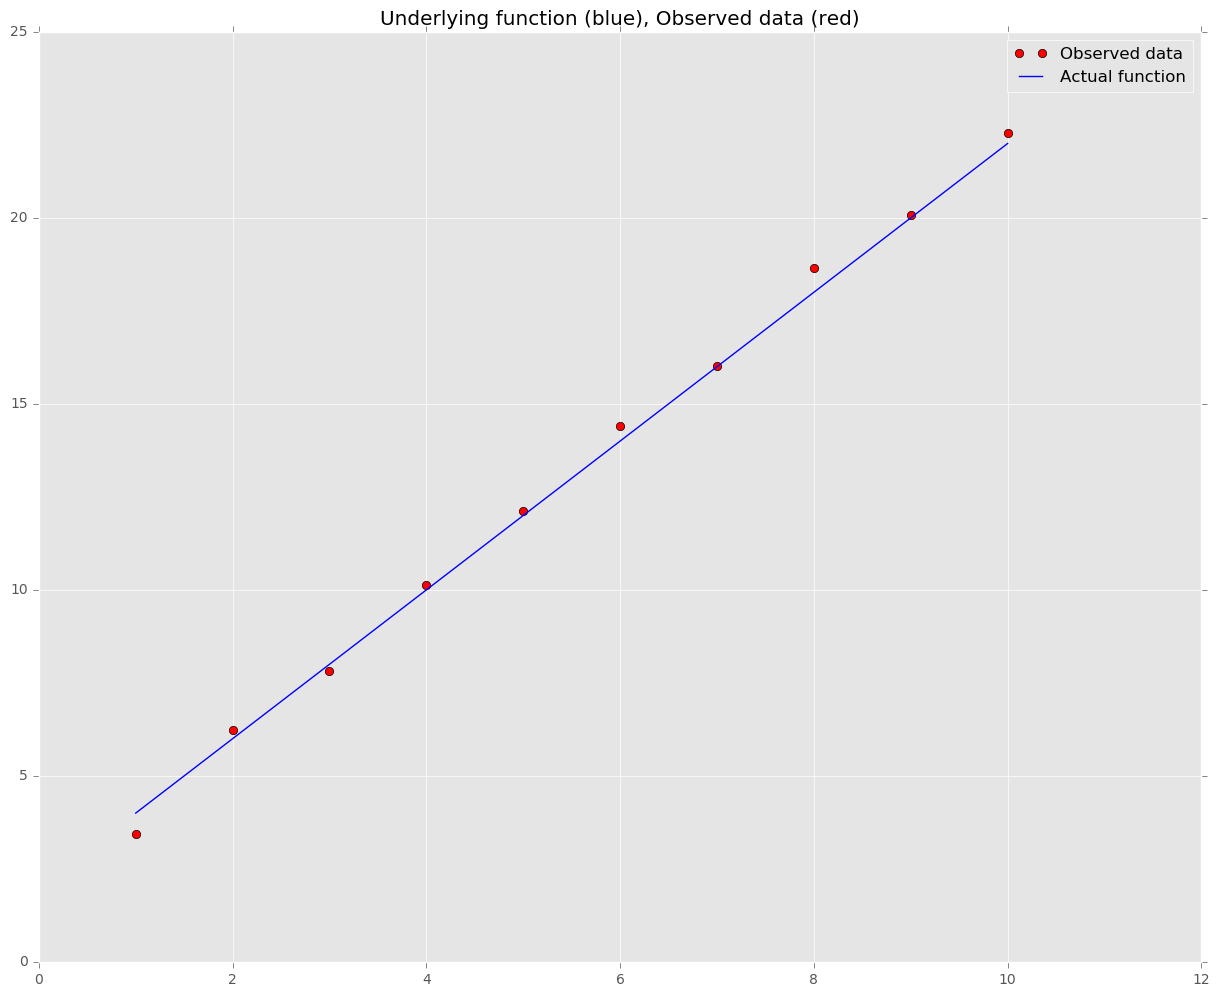

In [4]:
rng = np.random

# Parameters
learning_rate = 0.01
training_epochs = 1000
display_step = 50

# Training Data
train_X = np.linspace(1, 10, 10)
train_Y_actual = 2 * train_X + 2
train_Y = 2 * train_X + 2 + np.random.normal(loc=0, scale=0.5, size=train_X.size)

train_X = train_X.reshape(-1,1)
train_Y = train_Y.reshape(-1,1)

n_samples = train_X.shape[0]
print("No. of sample:", n_samples)

plt.plot(train_X,train_Y,'ro', label='Observed data')
plt.plot(train_X,train_Y_actual,'b', label='Actual function')
plt.ylim([0,25])
plt.xlim([0,12])
plt.title("Underlying function (blue), Observed data (red)")
plt.legend()
plt.show()

## Data Transformation

Given *data*, we need to transform the $x$ values of the data into a matrix containing rows of non linear features for each $x$ value. We will represent that matrix by $\mathbf{X}$. It should look as follows:
$$
  \mathbf{X} =
  \left[ {\begin{array}{cccccc}
   x_1 \\
   x_2 \\
   x_3 \\
   \vdots \\
   x_N \\
  \end{array} } \right]
$$

Similarly, we can represent y_train as a vector of observed values.
$$
\mathbf{y_{train}} =
\left[{\begin{array}{c} 
 y_1 \\ y_2\\y_3\\\vdots\\y_N 
 \end{array}}\right]
$$

Then we will have to represent the parameter values $\mathbf{w}$ as a vector of randomly initialised $1$ values.

With these representations, the we can simultaneously compute the predicted values for all the inputs with the following matrix multiplication.

$$
\mathbf{y_{pred}} = \mathbf{X}\mathbf{w} + \mathbf{b}
$$

Therefore, we can calculate the cost via

$$
\mathbf{cost} = \frac{\sum(\mathbf{pred}-\mathbf{Y})^2}{2 * \mathbf n\_samples}
$$

> Note: minimize() in Tensorflow train module knows to modify W and b because Variable objects are trainable=True by default. So no need to update them manually like we did it earlier non-tensorflow model.

## Build Tensorflow graph

In [5]:
# tf Graph Input
X = tf.placeholder(tf.float32, [None,1])
Y = tf.placeholder(tf.float32)

# Set model weights
W = tf.get_variable("weight", [1, 1], initializer=tf.zeros_initializer)
b = tf.get_variable("bias", [1], initializer=tf.zeros_initializer)

# Construct a linear model
pred = tf.add(tf.matmul(X,W), b)

# Mean squared error
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples)
# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

show_graph(tf.get_default_graph().as_graph_def())

### Train model

Epoch: 0050 cost= 0.210524514 W = [[ 2.25109124]]  b= [ 0.46926466]
Epoch: 0100 cost= 0.176716402 W = [[ 2.2326045]]  b= [ 0.59796828]
Epoch: 0150 cost= 0.149316877 W = [[ 2.21596169]]  b= [ 0.7138319]
Epoch: 0200 cost= 0.127112165 W = [[ 2.20097923]]  b= [ 0.81813633]
Epoch: 0250 cost= 0.109116748 W = [[ 2.18749166]]  b= [ 0.91203517]
Epoch: 0300 cost= 0.094532892 W = [[ 2.17534971]]  b= [ 0.99656612]
Epoch: 0350 cost= 0.082713619 W = [[ 2.1644187]]  b= [ 1.07266402]
Epoch: 0400 cost= 0.073135063 W = [[ 2.15457845]]  b= [ 1.14117002]
Epoch: 0450 cost= 0.065372303 W = [[ 2.14572001]]  b= [ 1.2028414]
Epoch: 0500 cost= 0.059081305 W = [[ 2.13774514]]  b= [ 1.25836015]
Epoch: 0550 cost= 0.053982824 W = [[ 2.13056588]]  b= [ 1.30834055]
Epoch: 0600 cost= 0.049851079 W = [[ 2.12410307]]  b= [ 1.35333407]
Epoch: 0650 cost= 0.046502534 W = [[ 2.11828518]]  b= [ 1.39383852]
Epoch: 0700 cost= 0.043788642 W = [[ 2.11304736]]  b= [ 1.43030262]
Epoch: 0750 cost= 0.041589398 W = [[ 2.10833216]]  b

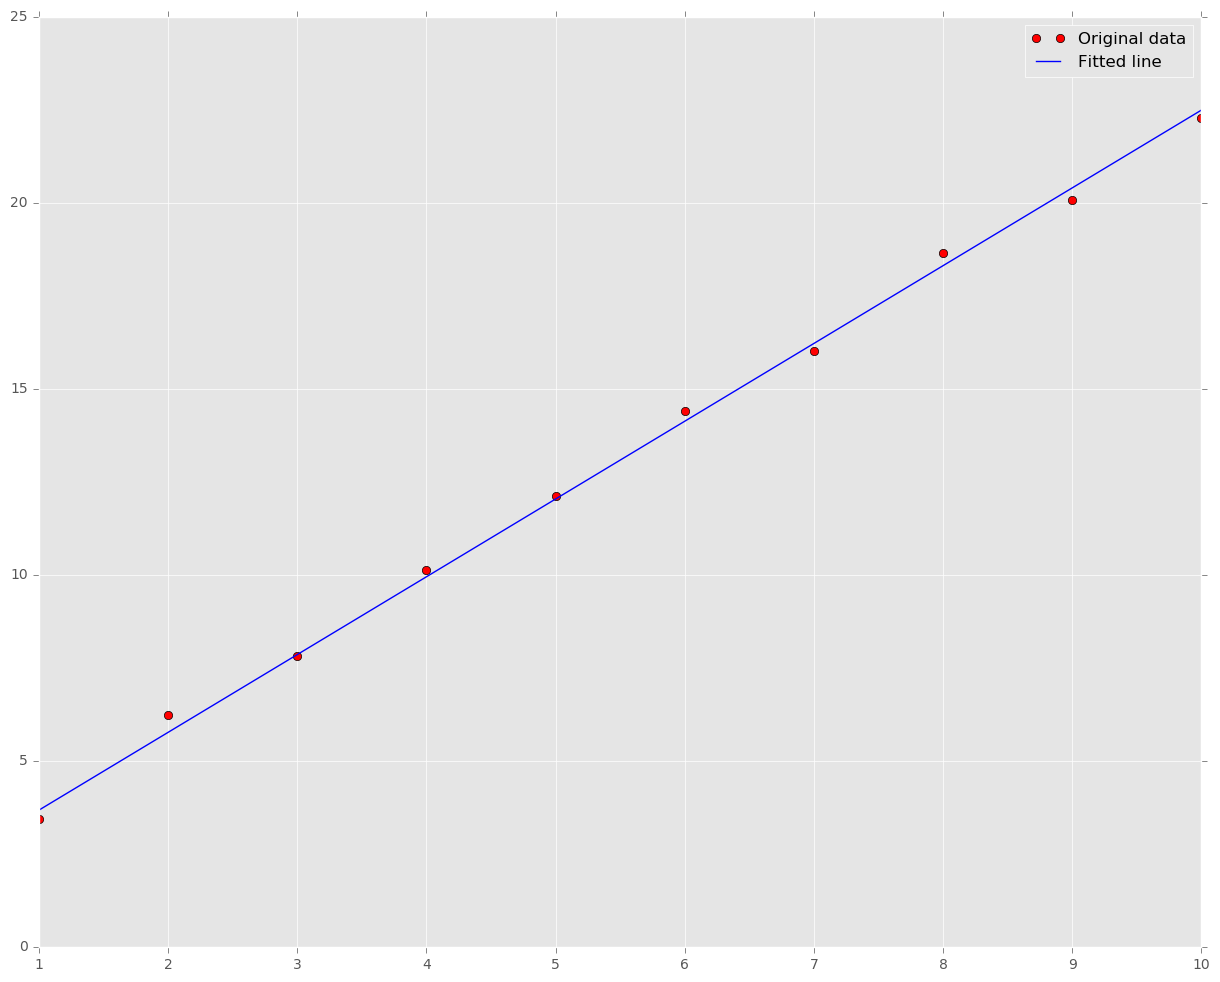

In [6]:
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        sess.run(optimizer, feed_dict={X: train_X, Y: train_Y})

        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(cost, feed_dict={X: train_X, Y:train_Y})
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
                "W =", sess.run(W), " b=", sess.run(b))

    print("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: train_X, Y: train_Y})
    print("Training cost=", training_cost, "W =", sess.run(W), "b =", sess.run(b), '\n')

    # Graphic display
    plt.plot(train_X, train_Y, 'ro', label='Original data')
    plt.plot(train_X, sess.run(W) * train_X + sess.run(b), 'b', label='Fitted line')
    plt.legend()
    plt.show()